In [ ]:
!pip install lightkurve
!pip install exoplanet

In [ ]:
!pip install pymc3_ext
!pip install celerite2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.0/922.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import exoplanet

In [ ]:
lc_file = lk.search_lightcurve("WASP-50")
lc_file

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,382391899,0.0
1,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
2,TESS Sector 04,2018,QLP,1800,382391899,0.0
3,TESS Sector 04,2018,TASOC,120,382391899,0.0
4,TESS Sector 04,2018,GSFC-ELEANOR-LITE,1800,382391899,0.0
5,TESS Sector 04,2018,TASOC,1800,382391899,0.0
6,TESS Sector 04,2018,TASOC,1800,382391899,0.0
7,TESS Sector 04,2018,TGLC,1800,382391899,0.0
8,TESS Sector 31,2020,SPOC,20,382391899,0.0


In [ ]:
data = lc_file.download(flux_column="pdcsap_flux")
data

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1410.907697206209,6.2585239e+03,1.1557840e+01,5.0703231e-03,132082,2023.38207,671.63645,5.5623047e+03,9.8813648e+00,1.3285054e+03,3.6023982e+00,6.2585239e+03,1.1557840e+01,0,———,———,———,———,2023.38207,1.3730535e-03,671.63645,1.3222167e-03,1.7119116e-01,-7.4971467e-02
1410.909086125265,6.2618818e+03,1.1560862e+01,5.0703539e-03,132083,2023.38158,671.63679,5.5648628e+03,9.8839474e+00,1.3226848e+03,3.6078129e+00,6.2618818e+03,1.1560862e+01,0,———,———,———,———,2023.38158,1.3729050e-03,671.63679,1.3212519e-03,1.7052230e-01,-7.5365342e-02
1410.9104750443212,6.2734663e+03,1.1561573e+01,5.0703846e-03,132084,2023.38162,671.63911,5.5744697e+03,9.8845558e+00,1.3216846e+03,3.6024897e+00,6.2734663e+03,1.1561573e+01,0,———,———,———,———,2023.38162,1.3705732e-03,671.63911,1.3218751e-03,1.7002426e-01,-7.2002925e-02
1410.9118639633766,6.2620503e+03,1.1560617e+01,5.0704153e-03,132085,2023.38511,671.63758,5.5652754e+03,9.8837395e+00,1.3176370e+03,3.6008630e+00,6.2620503e+03,1.1560617e+01,0,———,———,———,———,2023.38511,1.3725566e-03,671.63758,1.3242735e-03,1.7370598e-01,-7.5171642e-02
1410.9132528828977,6.2437910e+03,1.1543425e+01,5.0704465e-03,132086,2023.38463,671.64091,5.5491709e+03,9.8690395e+00,1.3236282e+03,3.5999038e+00,6.2437910e+03,1.1543425e+01,0,———,———,———,———,2023.38463,1.3740722e-03,671.64091,1.3251014e-03,1.7175424e-01,-7.0966899e-02
1410.9146418019538,6.2402651e+03,1.1548466e+01,5.0704773e-03,132087,2023.37978,671.64273,5.5482959e+03,9.8733501e+00,1.3276760e+03,3.6044683e+00,6.2402651e+03,1.1548466e+01,0,———,———,———,———,2023.37978,1.3764959e-03,671.64273,1.3247959e-03,1.6930321e-01,-6.6933408e-02
1410.91603072101,6.2718350e+03,1.1560477e+01,5.0705080e-03,132088,2023.38522,671.63449,5.5719609e+03,9.8836193e+00,1.3223142e+03,3.6069922e+00,6.2718350e+03,1.1560477e+01,0,———,———,———,———,2023.38522,1.3712582e-03,671.63449,1.3230841e-03,1.7464249e-01,-7.6113977e-02
1410.9174196400654,6.2675566e+03,1.1555481e+01,5.0705387e-03,132089,2023.38215,671.63953,5.5690479e+03,9.8793468e+00,1.3215554e+03,3.5928783e+00,6.2675566e+03,1.1555481e+01,0,———,———,———,———,2023.38215,1.3702476e-03,671.63953,1.3209442e-03,1.7185172e-01,-7.0966110e-02


In [ ]:
lc = data.remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

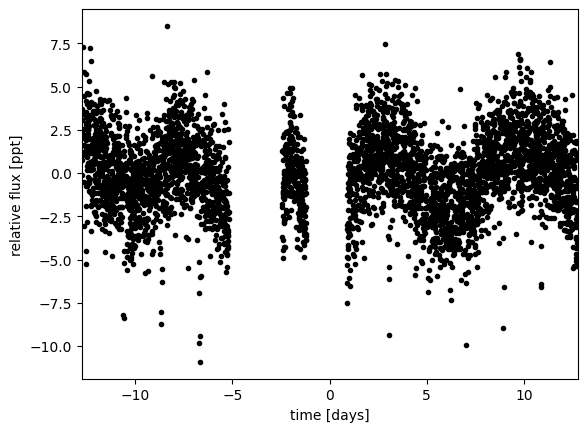

In [ ]:
# For the purposes of this example, we'll discard some of the data
m = (lc.quality == 0) & (
    np.random.default_rng(261136679).uniform(size=len(time)) < 0.3
)

with fits.open(data.filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux[m] - 1.0), dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

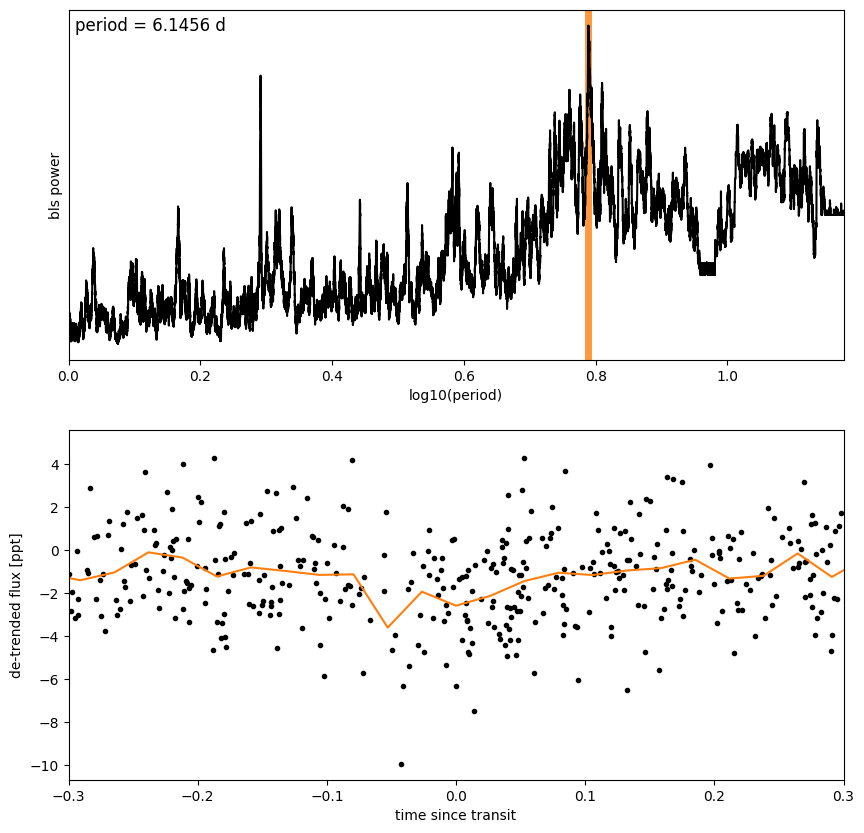

In [ ]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

In [ ]:
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from Huang et al (2018)
        M_star_huang = 0.861, 0.057
        R_star_huang = 	0.855, 0.019
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star_huang[0], sd=M_star_huang[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star_huang[0], sd=R_star_huang[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -10554.27905539114 -> -10421.184171212963
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -10421.184171212963 -> -10420.886590096508
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -10420.886590096508 -> -10418.324728789758
optimizing logp for variables: [t0, log_period]


message: Optimization terminated successfully.
logp: -10418.324728789758 -> -10411.405049952195
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -10411.405049952195 -> -10409.976187292015
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -10409.976187292015 -> -10406.186561682027
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -10406.186561682027 -> -10397.39897455213
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -10397.39897455213 -> -10395.43256778575
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -10395.43256778575 -> -10395.432524820313
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -10395.432524820313 -> -10395.269145597447
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -10395.269145597447 -> -9667.9798009005


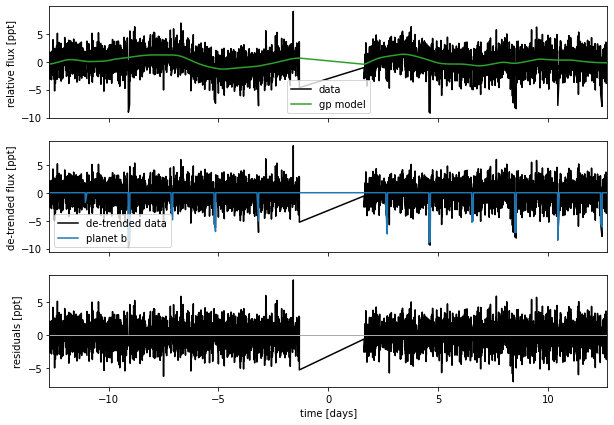

In [ ]:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)

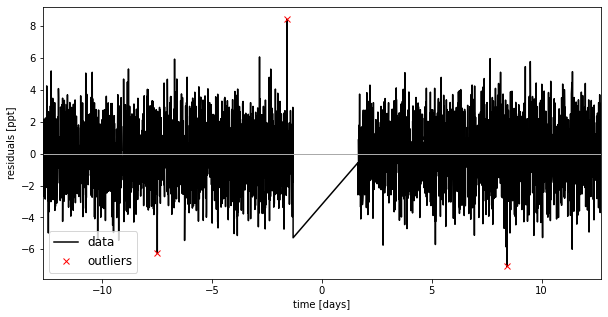

In [ ]:
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -9639.038446735018 -> -9638.916410400363
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -9638.916410400363 -> -9638.91592759546
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -9638.91592759546 -> -9638.91587751304
optimizing logp for variables: [t0, log_period]


message: Optimization terminated successfully.
logp: -9638.91587751304 -> -9638.915822829791
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -9638.915822829791 -> -9638.915779203444
optimizing logp for variables: [log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: -9638.915779203444 -> -9638.915776281867
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -9638.915776281867 -> -9638.915755789232
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -9638.915755789232 -> -9638.915755608155
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -9638.915755608155 -> -9638.915607685856
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -9638.915607685856 -> -9638.915604233232
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -9638.915604233232 -> -9638.915520330906


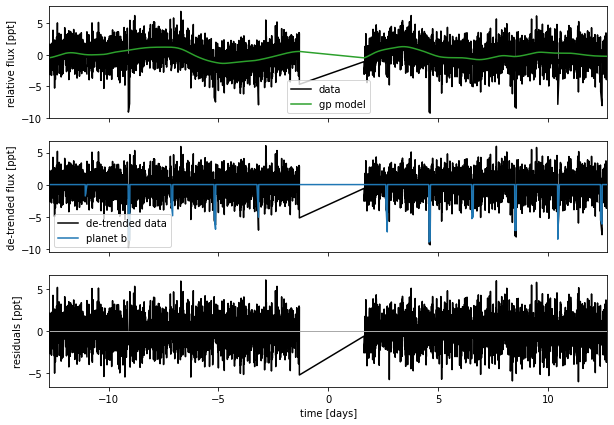

In [ ]:
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

In [ ]:
import platform

with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1 if platform.system() == "Darwin" else 2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,-0.124,1.905,-3.055,2.953,0.082,0.058,708.0,1464.0,1.01
ecc,0.175,0.138,0.002,0.452,0.010,0.007,263.0,330.0,1.01
r_pl,0.101,0.028,0.071,0.156,0.001,0.001,345.0,532.0,1.01
b,0.614,0.185,0.217,0.947,0.018,0.013,163.0,51.0,1.02
t0,-11.025,0.001,-11.027,-11.024,0.000,0.000,501.0,340.0,1.00
period,1.955,0.000,1.955,1.955,0.000,0.000,1164.0,1336.0,1.00
r_star,0.855,0.019,0.816,0.891,0.000,0.000,1882.0,1556.0,1.00
m_star,0.856,0.060,0.740,0.965,0.002,0.001,1077.0,564.0,1.00
u_star[0],0.664,0.455,0.004,1.470,0.014,0.011,1011.0,1028.0,1.00
u_star[1],0.013,0.406,-0.730,0.749,0.011,0.009,1231.0,1144.0,1.00


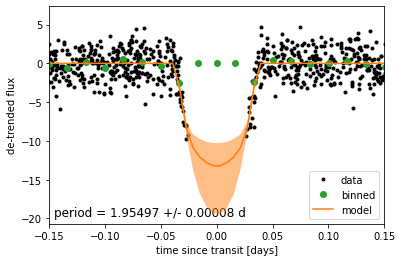

In [ ]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras["gp_pred"] + map_soln["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


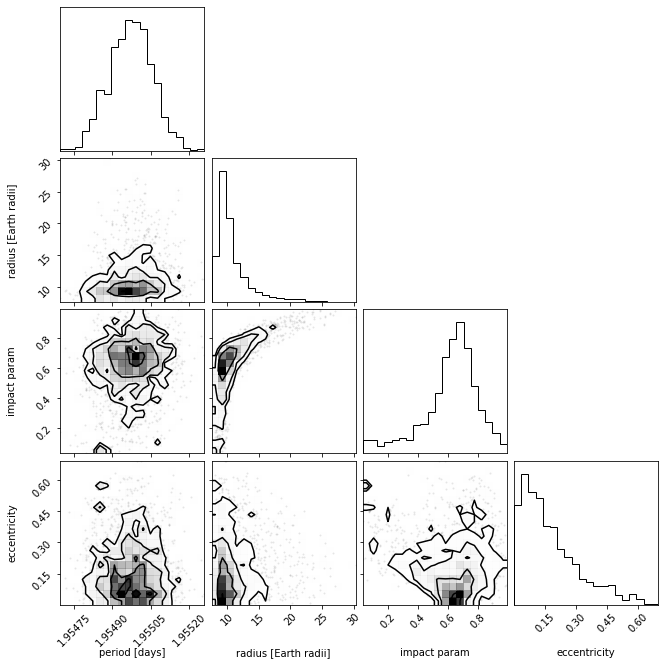

In [ ]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["period", "r_earth", "b", "ecc"],
    labels=[
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)